In [5]:
# https://keras.io/examples/vision/mnist_convnet/
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from matplotlib import pyplot as plt
import pdb
import os
import pandas as pd
import cv2
from shutil import copyfile
from sklearn.model_selection import train_test_split

In [6]:
db = pd.read_csv('train.csv', usecols=['File Name', 'Category'])
db_dict = dict(zip(db['File Name'], db['Category']))
categories_db = pd.read_csv('category.csv')
categories_dict = dict(zip(categories_db['Category'], categories_db.index))
input_dir = 'train_color_64'
processed_list = os.listdir(input_dir)
try:
    processed_list.remove('.DS_Store')
except:
    pass
train_list = processed_list[:int(len(processed_list)*0.9)]
val_list = processed_list[int(len(processed_list)*0.9):]
x_train = np.zeros((r*len(train_list), 64, 64, 3))
x_val = np.zeros((r*len(val_list), 64, 64, 3))
y_train = list()
y_val = list()
fail_list = list()
num_classes = 100

try:
    processed_list.remove('.DS_Store')
except:
    pass
data_list = processed_list
x_data = np.zeros((len(data_list), 64, 64, 3))
y_data = list()
num_classes = 100

for i, img_id in enumerate(data_list):
    img = cv2.imread(input_dir + '/' + img_id, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (64,64))
    x_data[i] += img/255
    y_data.append(categories_dict[db_dict[img_id]])


y_data = keras.utils.to_categorical(y_data, num_classes)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.10, shuffle=True)

In [8]:
input_shape = (64, 64, 3)
# Basic model architecture taken from https://colab.research.google.com/drive/1C8tLA5__49o-_3vFk3paxPMfHOgYUctG?usp=sharing.
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                        

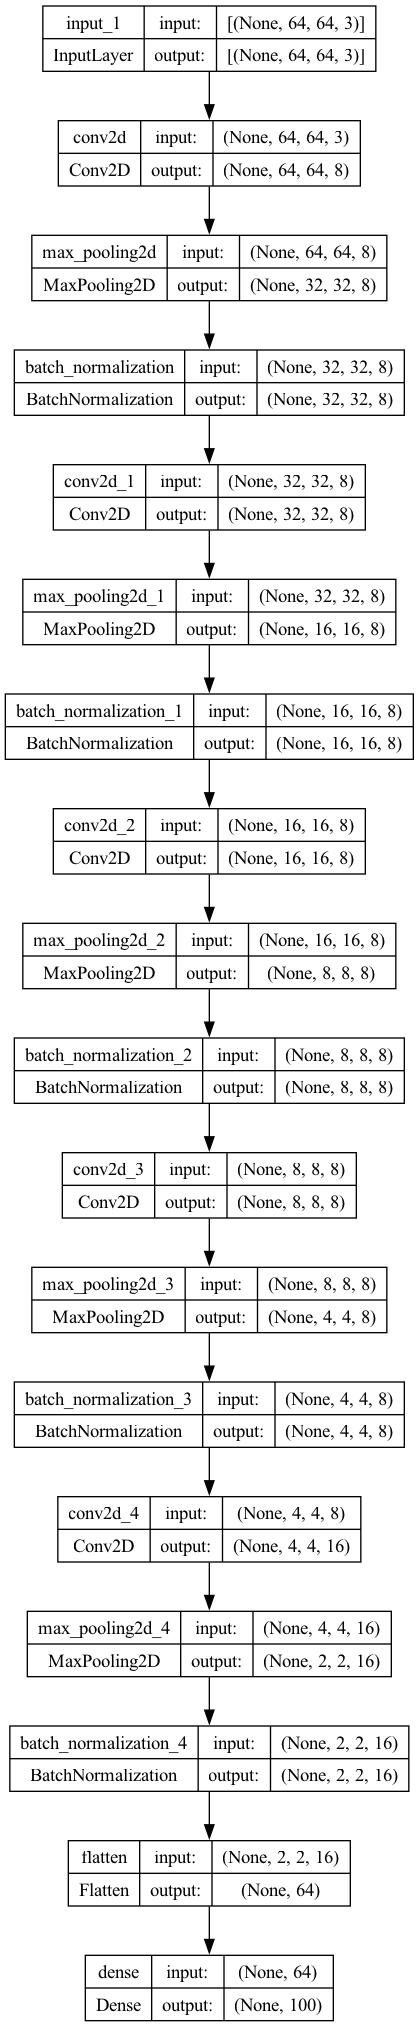

In [9]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [10]:
callback = keras.callbacks.ModelCheckpoint(filepath="training_ckpt/cp-{epoch:04d}.ckpt", save_weights_only=True, save_freq=1)

In [12]:
batch_size = 32
epochs = 250
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [13]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/250
1429/1501 [===========================>..] - ETA: 2s - loss: 4.3309 - accuracy: 0.0585

KeyboardInterrupt: 

In [20]:
def gen_submission_file(processed_test_dir, model, categories_dict):
    def extract_ids():
        img_ids = os.listdir(processed_test_dir)
        img_Ids = [int(img_id.split('.')[0]) for img_id in img_ids]
        return img_Ids


    def gen_test_data():
        processed_list = os.listdir(processed_test_dir)
        try:
            processed_list.remove('.DS_Store')
        except:
            pass
        x_test = np.zeros((len(processed_list), 64, 64, 3))
        error_list = []
        for i, img_id in enumerate(processed_list):
            try:
                img = cv2.imread(processed_test_dir + '/' + img_id, cv2.IMREAD_UNCHANGED)
                x_test[i] += img.reshape((64,64,3))/255
            except:
                error_list.append(img_id)
        print(len(error_list))

        return x_test

    def gen_categories(x_test):
        predictions = np.argmax(model.predict(x_test), axis=-1)
        inverse_categories_dict = {value:key for key,value in categories_dict.items()}
        categories= [inverse_categories_dict[prediction] for prediction in predictions]
        return categories

    def gen_csv(Ids, categories):
        default_category = 'Amy Ryan'
        total_ids = 4976+1
        excluded = list(set(range(total_ids))-set(Ids))
        excluded_data = [(exclude, default_category) for exclude in excluded]
        data = list(zip(Ids, categories))
        all_data = excluded_data+data

        print(len(all_data))
        columns = ['Id', 'Category']
        df = pd.DataFrame(all_data, columns=columns)
        df.sort_values(by=['Id'], inplace=True)
        df.to_csv('submission.csv', sep=',', index=False)

    Ids = extract_ids()
    x_test = gen_test_data()
    categories = gen_categories(x_test)
    gen_csv(Ids, categories)

gen_submission_file('test_processed', model, categories_dict)

0
152/152 [==============================] - 1s 5ms/step
143
4834
4977
